In [164]:
import numpy as np 
import pymdp 
from pymdp.maths import softmax, spm_cross
from pymdp.maths import spm_log_single
# %%
BC = np.array([[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5],[0,0,0,0],[0,0,0,0]])
BD = np.array([[0,0,0,0],[0,0,0,0],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])

s = np.array([1,0,0,0])

C = np.array([0.23688282, 0.0320586 , 0.64391426, 0.08714432])

def approximate_state(o):
    if o == 0:
        return np.array([1,0,0,0])
    elif o == 1:
        return np.array([0,0,0,1])

def infer_state(s,o):
    if o == 0:
        return softmax(spm_log_single(np.array([1,0,0,0])) + spm_log_single(s))
    elif o == 1:
        return softmax(spm_log_single(np.array([0,0,0,1])) + spm_log_single(s))

def sample_action(BC, BD, s):
    GC = (BC.dot(s).dot(spm_log_single(BC.dot(s)) - spm_log_single(C)))
    GD = (BD.dot(s).dot(spm_log_single(BD.dot(s)) - spm_log_single(C)))
    a = np.argmax(softmax(np.array([-GC,-GD])))
    
    return a, softmax(np.array([-GC,-GD])), GC, GD

def compute_prior(BC, BD,a,s):
    if a == 0:
        return BC.dot(s)
        #return np.array([1,0,0,0])
    elif a == 1:
        return BD.dot(s)
        #return np.array([0,0,0,1])

def update_B(qBC, qBD, a, s, s_prev, lr):
    if a == 0:
        qBC = qBC + lr*np.outer(s_prev, s)
    elif a == 1:
        qBD = qBD + lr* np.outer(s_prev, s)
    return qBC, qBD
lr = 0.3

pBC = BC
pBD = BD

def full_loop(BC, BD, pBD, pBC, lr, T):
    actions_over_time = []
    pBD_over_time = []
    pBC_over_time = []
    BD_over_time = []
    BC_over_time = []
    a= 1

    s = np.array([0,0,0,1])
    s_prior = s

    o = 1
    qp_over_time = []
    actions_over_time=[]
    for t in range(T):
        s = infer_state(s_prior,o)
        a, qp, GC, GD = sample_action(BC, BD, s)

        qp_over_time.append([qp,-1*GC,-1*GD])
        if t > 1:
            pBC, pBD = update_B(pBC, pBD,a,s, s_prev, lr)
            BC = pBC/ pBC.sum(axis=0)
            BD = pBD/ pBD.sum(axis=0)
        o = a
        s_prior = compute_prior(BC,BD,a,s)
        s_prev = s
        actions_over_time.append(a)
        pBD_over_time.append(pBD)
        pBC_over_time.append(pBC)
        BD_over_time.append(BD)
        BC_over_time.append(BC)
    return actions_over_time, pBD_over_time, pBC_over_time, BD_over_time, BC_over_time

def approximate_loop(BC, BD, pBD, pBC, lr, T):
    actions_over_time = []
    pBD_over_time = []
    pBC_over_time = []
    BD_over_time = []
    BC_over_time = []
    a= 1
    o = 1
    qp_over_time = []
    actions_over_time=[]
    for t in range(T):
        s = approximate_state(o)
        a, qp, GC, GD = sample_action(BC, BD, s)

        qp_over_time.append([qp,-1*GC,-1*GD])
        if t > 1:
            pBC, pBD = update_B(pBC, pBD, a,s, s_prev, lr)
            BC = pBC/ pBC.sum(axis=0)
            BD = pBD/ pBD.sum(axis=0)
        o = a
        s_prev = s
        actions_over_time.append(a)
        pBD_over_time.append(pBD)
        pBC_over_time.append(pBC)
        BD_over_time.append(BD)
        BC_over_time.append(BC)
    return actions_over_time, pBD_over_time, pBC_over_time, BD_over_time, BC_over_time, np.array(qp_over_time)[:,0],np.array(qp_over_time)[:,1],np.array(qp_over_time)[:,2]


In [157]:
actions_over_time, pBD_over_time, pBC_over_time, BD_over_time, BC_over_time = full_loop(BC, BD, pBD, pBC,lr, T=100)

In [165]:
actions_over_time, pBD_over_time, pBC_over_time, BD_over_time, BC_over_time, qpi,GC,GD = approximate_loop(BC, BD, pBD, pBC,lr, T=100)

<ipython-input-164-600fb2f1ec25>:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return actions_over_time, pBD_over_time, pBC_over_time, BD_over_time, BC_over_time, np.array(qp_over_time)[:,0],np.array(qp_over_time)[:,1],np.array(qp_over_time)[:,2]


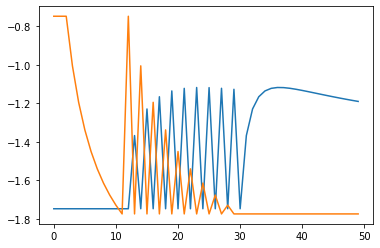

In [169]:
plt.plot(GC[:50])
plt.plot(GD[:50])

In [133]:
def GD(BC,t, s, C):
    return (BC.dot(s) + lr*s*t / ((BC.dot(s) + lr*s*t).sum(axis=0))).dot(spm_log_single(BC.dot(s) + lr*s*t / ((BC.dot(s) + lr*s*t).sum(axis=0))) - spm_log_single(C))

In [152]:
def GC(BC,t, s, C):
    return (BC.dot(s).dot(spm_log_single(BC.dot(s)) - spm_log_single(C)))

In [366]:
def qBt(t,BD,BC, sD, sC,lr, tau1=11, tau2=30):
    if t < tau1: 
        return BD + lr* np.outer(sD, sD)*t
    elif t >= tau1 and t <= tau2:
        if t % 2 != 0 :
            t = tau1 + ((t-tau1)/2)
        else:
            t = tau1 + ((t-tau1)/2) - 0.5
        return BD + lr* np.outer(sD, sD)*(tau1) + lr* np.outer(sD, sC)*(t-tau1) + lr* np.outer(sC, sD)*(t-tau1)
    elif t > tau2:
        tau2t = tau1 + ((tau2-tau1-1)/2)
        return BD + lr* np.outer(sD, sD)*(tau1) + lr* np.outer(sD, sC)*(tau2t-tau1) + lr* np.outer(sC, sD)*(tau2t-tau1)+ lr* np.outer(sC, sC)*(t-tau2)



In [565]:
def qBt(t,BD,BC, sD, sC,lr, tau1=11, tau2=30):
    if t <= tau1: 
        return BC + BD + lr* np.outer(sD, sD)*(t)
    elif t > tau1 and t < tau2:
        if t % 2 == 0 :
            t = tau1 + ((t-tau1)/2)+ 0.5
        else:
            t = tau1 + ((t-tau1)/2)
        return BC + BD +  lr* np.outer(sD, sD)*(tau1) + lr* np.outer(sD, sC)*(t-tau1) + lr* np.outer(sC, sD)*(t-tau1)
    elif t >= tau2:
        tau2t = tau1 + ((tau2-tau1-1)/2)
        return BC + BD +  lr* np.outer(sD, sD)*(tau1) + lr* np.outer(sD, sC)*(tau2t-tau1) + lr* np.outer(sC, sD)*(tau2t-tau1)+ lr* np.outer(sC, sC)*(t-tau2)



In [568]:
qbD = []
for t in [0] + list(range(50)):
    qbD.append(qBt(t,BD,BC, sD=np.array([0,0,0,1]), sC = np.array([1,0,0,0]),lr = 0.3, tau1=9.7, tau2=30))

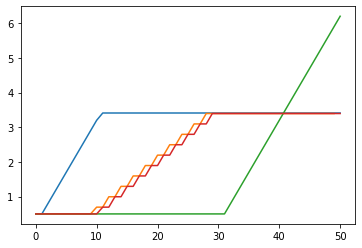

In [569]:
plt.plot([q[-1,-1] for q in qbD])
plt.plot([q[0,-1] for q in qbD[1:]])
plt.plot([q[0,0] for q in qbD])
plt.plot([q[-1,0] for q in qbD])

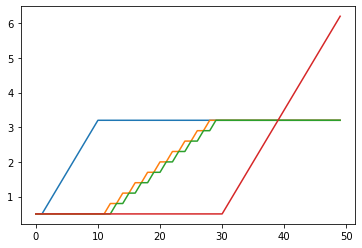

In [530]:
plt.plot([q[-1,-1] for q in pBD_over_time[:50]])
plt.plot([q[-1,0] for q in pBD_over_time[:50]])
plt.plot([q[0,-1] for q in pBC_over_time[:50]])
plt.plot([q[0,0] for q in pBC_over_time[:50]])

In [356]:
pBD_over_time[0][-1,-1]

0.5

In [ ]:
pBD_over_time[:50]][]

In [153]:
GDs = []
for t in range(100):
    GDs.append(GD(BD, t, s = np.array([0,0,0,1]),C=C) )

GCs = []
for t in range(100):
    GCs.append(GC(BC, t, s = np.array([1,0,0,0]),C=C) )


In [160]:
pBD_over_time

[array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.8]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 1.1]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 1.4]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 1.7]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 2. ]]),
 array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 2.3]]),
 array([[0. , 0. , 0. , 

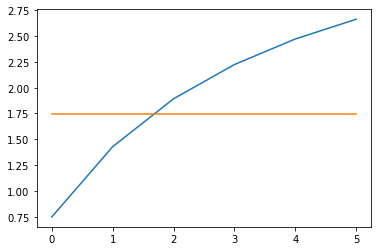

In [156]:
import matplotlib.pyplot as plt 
plt.plot(GDs[:6])
plt.plot(GCs[:6])

In [132]:
sD.dot(np.array([0,0,0,1]))

array([0, 0, 0, 1])

In [129]:
pBD + 2*(lr*sD)

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 1.1]])

In [119]:
lr

0.3

In [69]:
pBD1 = [x[-1,-1] for x in pBD_over_time]
pBD2 = [x[-1,0] for x in pBD_over_time]

In [110]:
sD = np.outer(np.array([0,0,0,1]), np.array([0,0,0,1]))

In [112]:
sD

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

In [70]:
collect_PBD = []
collect_PBD2 = []
collect_BD = []
collect_PBC = []

for i in range(5):
    collect_PBD.append(simple(0.5,i))
    collect_BD.append(simple(1,i)/(1+simple(1,i)))

for i in range(10):
    collect_PBD.append(collect_PBD[-1])

for i in [0,0,1,1,2,2,3,3,4,4,5,5,6,6]:
    collect_PBD2.append(simple(0,i))


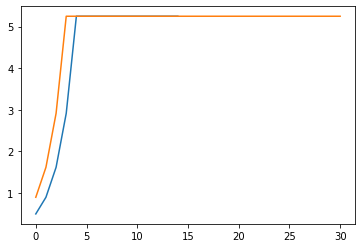

In [71]:
import matplotlib.pyplot as plt
plt.plot(collect_PBD)
plt.plot(pBD1)

In [72]:
prior_BC = np.array([[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5],[0,0,0,0],[0,0,0,0]])
sC = np.array([1,0,0,0])
GC = -(prior_BC.dot(sC).dot(spm_log_single(prior_BC.dot(sC)) - spm_log_single(C)))


In [131]:
spm_log_single(C)

array([-1.44018969, -3.4401898 , -0.4401897 , -2.44018968])

In [129]:
print(prior_BC.dot(sC))
print(spm_log_single(prior_BC.dot(sC)))

[0.5 0.5 0.  0. ]
[ -0.69314718  -0.69314718 -36.84136149 -36.84136149]


In [130]:
print(prior_BD.dot(sD))
print(spm_log_single(prior_BD.dot(sD)))

[0.  0.  0.5 0.5]
[-36.84136149 -36.84136149  -0.69314718  -0.69314718]


In [78]:
spm_log_single(prior_BC.dot(sC)) - spm_log_single(C)

array([  0.74704251,   2.74704262, -36.40117179, -34.4011718 ])

In [83]:
prior_BD = np.array([[0,0,0,0],[0,0,0,0],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])
sD = np.array([0,0,0,1])
GD = (prior_BD.dot(sD).dot(spm_log_single(prior_BD.dot(sD)) - spm_log_single(C)))


In [132]:
def GC_t(t):
    return pB_t(t)*(spm_log_single(pB_t(t))-spm_log_single(C[1])) + (1-pB_t(t)) * (spm_log_single((1-pB_t(t)))-spm_log_single(C[0]))

In [114]:
def GD_t(t):
    return pB_t(t)*(spm_log_single(pB_t(t))-spm_log_single(C[3])) + (1-pB_t(t)) * (spm_log_single((1-pB_t(t)))-spm_log_single(C[2]))

In [147]:
(-spm_log_single(C[2]) + spm_log_single(C[0])) / (-spm_log_single(C[1]) + spm_log_single(C[3]) - spm_log_single(C[2]) + spm_log_single(C[0]))

-8023094.09942872

In [148]:
-spm_log_single(C[2]) + spm_log_single(C[0])

-0.9999999921105411

In [151]:
- 1 * spm_log_single(C[1]) + spm_log_single(C[3]) - spm_log_single(C[2]) + spm_log_single(C[0])

1.2464019238933588e-07

In [154]:
(1+5)/(2+5)

0.8571428571428571

In [152]:
- 1 * spm_log_single(C[1]) + spm_log_single(C[3]) 

1.0000001167507335

In [153]:
- spm_log_single(C[2]) + spm_log_single(C[0])

-0.9999999921105411

In [144]:
(-spm_log_single(C[1]) + spm_log_single(C[3]) - spm_log_single(C[2]) + spm_log_single(C[0]))

1.2464019238933588e-07

In [146]:
1 / (-spm_log_single(C[1]) + spm_log_single(C[3]) )

0.9999998832492801

In [134]:
print(GD_t(0))
print(GC_t(0))

0.7470425106965353
1.7470425651271726


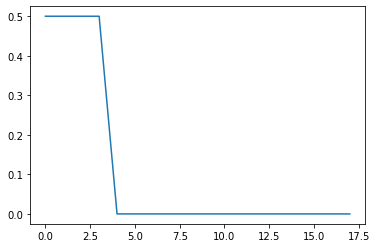

In [117]:
plt.plot([0.5,0.5,0.5,0.5] + collect_PBD2)

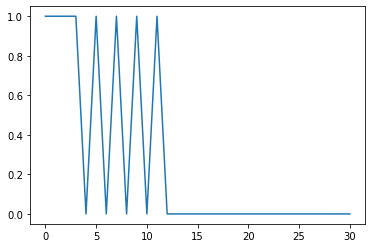

In [118]:
plt.plot(actions_over_time)

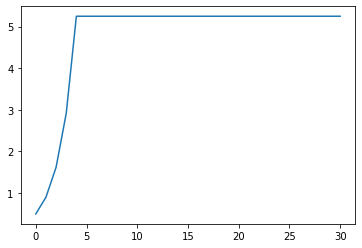

In [743]:
plt.plot(pBD1)

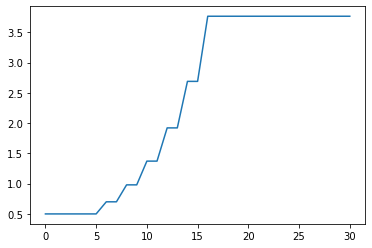

In [746]:
plt.plot(pBD2)

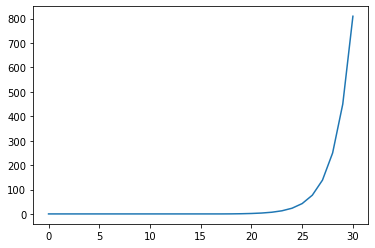

In [728]:
plt.plot(pBC_over_time)

<ipython-input-722-6302fdfb0d00>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot([x[0] for x in np.array(np.array(qp_over_time)[:,0])])


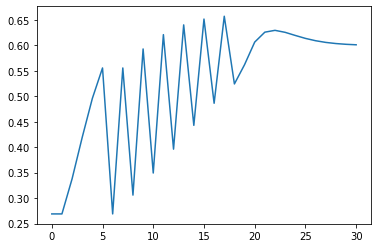

In [722]:
plt.plot([x[0] for x in np.array(np.array(qp_over_time)[:,0])])

In [723]:
(1+0.8)

1.8

<ipython-input-724-93985c248eb2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(-np.array(qp_over_time)[:,2])


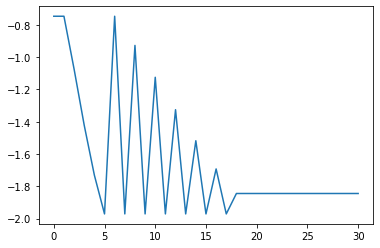

In [724]:
plt.plot(-np.array(qp_over_time)[:,2])

<ipython-input-725-24709c8fe238>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(-np.array(qp_over_time)[:,1])


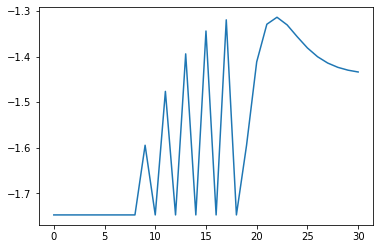

In [725]:
plt.plot(-np.array(qp_over_time)[:,1])

In [692]:
-np.array(qp_over_time)[:,2]

<ipython-input-692-4b2cdd3e2241>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  -np.array(qp_over_time)[:,2]


array([-0.7470425106965353, -0.7470425106965353, -1.07414741376076,
       -1.3434994947315901, -1.541228805925912, -1.6843701740040178,
       -1.7901358640098706, -0.7470425106965353, -1.7901358640098706,
       -0.9276630907431656, -1.7901358640098706, -1.0957914176266228,
       -1.7901358640098706, -1.2430632056394146, -1.7901358640098706,
       -1.3683600413900825, -1.7901358640098706, -1.4738391616966822,
       -1.7901358640098706, -1.5625931239283128, -1.7901358640098706,
       -1.6376237308592372, -1.7901358640098706, -1.701502575595255,
       -1.7901358640098706, -1.7563225188027665, -1.7563225188027665,
       -1.7563225188027665, -1.7563225188027665, -1.7563225188027665,
       -1.7563225188027665], dtype=object)

In [669]:
BD_over_time

[array([[0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ],
        [0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5]]),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.35714286],
        [0.5       , 0.5       , 0.5       , 0.64285714]]),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.26119403],
        [0.5       , 0.5       , 0.5       , 0.73880597]]),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.19957447],
        [0.5       , 0.5       , 0.5       , 0.80042553]]),
 array([[0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       ],
        [0.5      , 0.5      , 0.5      , 0.1589486],
        [0.5  

In [670]:
BC_over_time

[array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. ]]),
 array([[0.5       , 0.5

In [664]:
pBD_over_time

[0.5,
 0.9,
 1.4142857142857144,
 2.0053304904051172,
 2.645670915937032,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089,
 3.318512032923089]

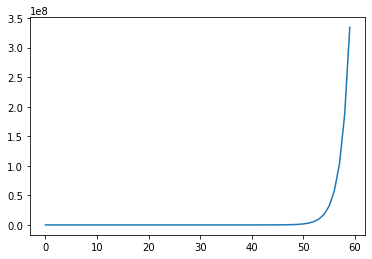

In [659]:
plt.plot(pBC_over_time)

In [624]:
0.5*1.6 / (0.5*1.6+0.5)

0.6153846153846154

In [634]:
0.5*1.6**2 + (0.5*1.6/ (0.5*1.6+0.5))

1.8953846153846157

In [626]:
1.1*0.5

0.55

In [625]:
0.5*1.6**2

1.2800000000000002

In [613]:
pBD.sum(axis=0)

array([1. , 1. , 1. , 1.3])

In [561]:
pBD[-2:,:]

array([[0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])

In [467]:
print(p_prior)

[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]


In [468]:
np.outer(s,s)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

In [469]:
np.multiply(p_prior, 1 + lr*np.outer(s,s))

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.8]])

In [473]:
np.multiply(p_prior, 1 + lr*np.outer(s,s))

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 1.28]])

In [470]:
qBD = p_prior + lr * np.multiply(np.outer(s, s),p_prior)


In [571]:
np.outer(s,s)[3]

array([0, 0, 0, 1])

In [563]:
q4 = pBD[3]

In [573]:
q4

array([0.5, 0.5, 0.5, 0.5])

In [589]:
1.6*0.5

0.8

1.2800000000000002

In [590]:
1.6*0.8

1.2800000000000002

In [580]:
0.5*np.exp((1+lr))

0.10094825899732769

In [572]:
np.multiply(np.outer(s, s)[3],q4)

array([0. , 0. , 0. , 0.5])

In [568]:
q42 = q4 + lr * np.multiply(np.outer(s, s)[3],q4)
print(q42)

[0.8 0.8 0.8 0.8]


In [569]:
R = np.multiply(p_prior, 1 + lr*np.outer(s,s))


In [479]:
p_prior

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.8]])

In [546]:
np.exp(eig)

array([64.59610851,  1.54009766,  1.        ,  1.        ])

In [551]:
np.multiply(pBD, eigv[0] * np.exp(eig[0]))

array([[ -0.        ,   0.        ,   0.        ,   0.        ],
       [ -0.        ,   0.        ,   0.        ,   0.        ],
       [-15.45983746,  10.42664193,  24.75224217,   2.39038417],
       [-15.45983746,  10.42664193,  24.75224217,   2.39038417]])

In [558]:
np.multiply(eigv, np.exp(eig)).round(2)

array([[-30.92,   0.5 ,   0.77,   0.07],
       [-30.92,   0.5 ,  -0.63,  -0.74],
       [-30.92,   0.5 ,  -0.14,   0.67],
       [-36.12,  -1.28,  -0.  ,  -0.  ]])

In [493]:
A.dot(p_prior)

array([[0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.5 , 0.5 ],
       [0.5 , 0.5 , 0.5 , 1.28]])

In [482]:
A = np.matmul(R,np.linalg.pinv(p_prior))

In [485]:
pBD

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])

In [487]:
A.round(2)

array([[ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ],
       [-0. ,  0. , -1.6,  2.6]])

In [489]:
eig, eigv = np.linalg.eig(A)

In [588]:
1.6*0.5*2

1.6

In [491]:
v1, v2, v3, v4 = eigv

In [586]:
0.5*np.exp(0.6)

0.9110594001952544

In [495]:
v1.dot(np.exp(eig[0]))

array([ 0.        ,  0.        , 13.46373804,  0.        ])

In [496]:
1 + lr*np.outer(s,s)

array([[1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1.6]])

In [497]:
p_prior = qBD

In [498]:
t = 0
s = next_state(BC, BD,a,s_prior)
a = next_action(BC, BD, s)
print(np.multiply(p_prior, 1 + lr*np.outer(s,s)))
print(p_prior)
#pBC, pBD = update_B(pBC, pBD,pBC, pBD, a, s, s_prior, lr)
qBD = p_prior + lr * np.multiply(np.outer(s, s),p_prior)
p_prior = qBD
print(np.multiply(p_prior, 1 + lr*np.outer(s,s)))
print(qBD)
qBD = p_prior + lr * np.multiply(np.outer(s, s),p_prior)
p_prior = qBD
print(np.multiply(p_prior, 1 + lr*np.outer(s,s)))
print(qBD)
BC = pBC/ pBC.sum(axis=0)
BD = pBD/ pBD.sum(axis=0)

o = a
s_prior = prior(s,o)
actions_over_time.append(a)

[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.5   0.5   0.5   0.5  ]
 [0.5   0.5   0.5   2.048]]
[[0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.5  0.5  0.5  0.5 ]
 [0.5  0.5  0.5  1.28]]
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.5    0.5    0.5    0.5   ]
 [0.5    0.5    0.5    3.2768]]
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.5   0.5   0.5   0.5  ]
 [0.5   0.5   0.5   2.048]]
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.5     0.5     0.5     0.5    ]
 [0.5     0.5     0.5     5.24288]]
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.5    0.5    0.5    0.5   ]
 [0.5    0.5    0.5    3.2768]]


In [499]:
eig, eigv = np.linalg.eig(1 + lr*np.outer(s,s))

In [500]:
A = 1 + lr*np.outer(s,s)

In [501]:
A

array([[1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1.6]])

In [502]:
p_new = p_prior * A 

In [503]:
p_new * A

array([[0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.5     , 0.5     , 0.5     , 0.5     ],
       [0.5     , 0.5     , 0.5     , 8.388608]])

In [504]:
np.exp(A)

array([[2.71828183, 2.71828183, 2.71828183, 2.71828183],
       [2.71828183, 2.71828183, 2.71828183, 2.71828183],
       [2.71828183, 2.71828183, 2.71828183, 2.71828183],
       [2.71828183, 2.71828183, 2.71828183, 4.95303242]])

In [505]:
p_prior * np.exp(A)

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.35914091,  1.35914091,  1.35914091,  1.35914091],
       [ 1.35914091,  1.35914091,  1.35914091, 16.23009665]])

In [506]:
p_prior

array([[0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.5   , 0.5   , 0.5   , 0.5   ],
       [0.5   , 0.5   , 0.5   , 3.2768]])

In [507]:
np.exp(const)

array([[2.71828183, 1.        , 1.        , 1.        ],
       [1.        , 2.71828183, 1.        , 1.        ],
       [1.        , 1.        , 2.71828183, 1.        ],
       [1.        , 1.        , 1.        , 4.95303242]])

In [508]:
np.matmul(p_prior,np.exp(const))

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.85914091,  2.85914091,  2.85914091,  3.97651621],
       [ 5.63594091,  5.63594091,  5.63594091, 17.73009665]])

In [509]:
np.matmul(np.outer(s,s),p_prior)*lr

array([[0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.3    , 0.3    , 0.3    , 1.96608]])

In [510]:
np.multiply(np.outer(s,s),p_prior)*lr

array([[0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 1.96608]])

In [511]:
const = np.eye(4) + lr * v

In [512]:
p_prior*np.exp(-1*np.linalg.inv(const))

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.18393972, 0.5       ],
       [0.5       , 0.5       , 0.5       , 1.75394465]])

In [513]:
np.exp(-1*const)

array([[0.36787944, 1.        , 1.        , 1.        ],
       [1.        , 0.36787944, 1.        , 1.        ],
       [1.        , 1.        , 0.36787944, 1.        ],
       [1.        , 1.        , 1.        , 0.20189652]])

In [514]:
const * p_prior

array([[0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.5    , 0.     ],
       [0.     , 0.     , 0.     , 5.24288]])

In [515]:
np.multiply(np.exp(-1*const),p_prior)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.18393972, 0.5       ],
       [0.5       , 0.5       , 0.5       , 0.66157451]])

In [516]:
v = np.outer(s,s)

In [517]:
v

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

In [518]:
const = np.eye(4) + lr*v

In [519]:
eig

array([ 4.16815417e+00,  4.31845831e-01,  1.40511229e-16, -5.46509731e-18])

In [520]:
np.multiply(p_prior, eigv[0]) + np.multiply(p_prior, eigv[1]) + np.multiply(p_prior,eigv[2]) + np.multiply(p_prior,eigv[3])

array([[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-9.97567616e-01,  6.97054660e-02, -2.37185561e-17,
         1.06436917e-16],
       [-9.97567616e-01,  6.97054660e-02, -2.37185561e-17,
         9.38418968e-16]])

In [521]:
v1, v2, v3, v4 = eigv

In [522]:
v1

array([-0.47866157,  0.3228257 ,  0.76636945,  0.07401016])

In [523]:
p_prior

array([[0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.5   , 0.5   , 0.5   , 0.5   ],
       [0.5   , 0.5   , 0.5   , 3.2768]])

In [524]:
p_prior*v4

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [-2.79575256e-01, -4.14533082e-01, -1.76374222e-16,
        -6.00965365e-17],
       [-2.79575256e-01, -4.14533082e-01, -1.76374222e-16,
        -3.93848661e-16]])

In [525]:
p_prior*v1

array([[-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.23933079,  0.16141285,  0.38318473,  0.03700508],
       [-0.23933079,  0.16141285,  0.38318473,  0.24251649]])

In [526]:
t=1

In [527]:
(np.exp(t)*v1 + np.exp(t)*(t*v2) + np.exp(t)*(t*t*v3 + np.exp(t*8/5)*v4)

SyntaxError: unexpected EOF while parsing (<ipython-input-527-8015600c569a>, line 1)

In [ ]:
def pls(t):
    return np.multiply((np.exp(t)*v1 + np.exp(t)*(t*v1+v2) + np.exp(t)*(t*t*v1 + t*v2 + v3) + np.exp(t*8/5)*v4),p_prior)

In [ ]:
def pls(t):
    return p_prior* ( np.exp(t)*(v3) + np.exp(t*8/5)*v4)

In [ ]:
p_prior*v3

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. ],
       [0. , 0. , 0.5, 0. ]])

In [ ]:
pls(1)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.35914091, 2.47651621],
       [0.        , 0.        , 1.35914091, 2.47651621]])

In [ ]:
p_prior

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5]])

In [ ]:
np.multiply(v4,p_prior)

array([[0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0.5]])

In [ ]:
np.dot(np.exp(np.eye(4,4)),v1)

array([2.71828183, 1.        , 1.        , 1.        ])

In [ ]:
np.multiply(np.dot(v1, np.exp(t)),p_prior)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [1.35914091, 0.        , 0.        , 0.        ],
       [1.35914091, 0.        , 0.        , 0.        ]])

In [ ]:
pls(1)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [4.07742274, 2.71828183, 1.35914091, 2.47651621],
       [4.07742274, 2.71828183, 1.35914091, 2.47651621]])

In [ ]:
q

array([[2.71828183, 0.        , 0.        , 0.        ],
       [0.        , 2.71828183, 0.        , 0.        ],
       [0.        , 0.        , 2.71828183, 0.        ],
       [0.        , 0.        , 0.        , 4.95303242]])

In [ ]:
q / q.sum(axis=0)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
actions_over_time

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
